This notebook replicates the success model. We plan to add additional features on matchup data

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
import xgboost as xgb

In [39]:
coverage_preds = pd.read_csv("full_cb_wr_data_preds_v2.csv")
coverage_preds.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,epa,defenseWin,offenseWin,heightDef,nflId,height,displayName,heightOff,heightAdv,pred_man
0,2018090600,75,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,0.261827,False,True,74,2495454,74,Julio Jones,74,0,0.037823
1,2018090600,146,1,2552689,Ronald Darby,PHI,CB,2557034,Marvin Hall,ATL,...,-0.372360,True,False,74,2557034,74,Marvin Hall,74,0,0.045660
2,2018090600,146,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,-0.372360,True,False,74,2560854,74,Calvin Ridley,74,0,0.058134
3,2018090600,146,1,2557958,Sidney Jones,PHI,CB,2552418,Justin Hardy,ATL,...,-0.372360,True,False,74,2552418,74,Justin Hardy,74,0,0.056922
4,2018090600,168,1,2552689,Ronald Darby,PHI,CB,2533040,Mohamed Sanu,ATL,...,-0.702779,True,False,74,2533040,74,Mohamed Sanu,74,0,0.053701


In [40]:
len(coverage_preds)

45329

This is the correct length

In [41]:
plays = pd.read_csv("plays.csv")
games = pd.read_csv("games.csv")


In [42]:
# Configure plays data with relevant features
plays = (
    plays.merge(games, on="gameId", how="left")
    .loc[:, [
        "gameId", "playId", "quarter", "down", "yardsToGo",
        "yardlineNumber", "yardlineSide", "offenseFormation",
        "defendersInTheBox", "numberOfPassRushers",
        "preSnapVisitorScore", "preSnapHomeScore",
        "possessionTeam", "homeTeamAbbr", "visitorTeamAbbr"
    ]]
    .assign(
        yardline_100=lambda df: np.where(
            df["yardlineSide"] == df["possessionTeam"],
            df["yardlineNumber"],
            100 - df["yardlineNumber"]
        ),
        poss_home=lambda df: (df["possessionTeam"] == df["homeTeamAbbr"]),
        poss_score_diff=lambda df: np.where(
            df["poss_home"],
            df["preSnapHomeScore"] - df["preSnapVisitorScore"],
            df["preSnapVisitorScore"] - df["preSnapHomeScore"]
        )
    )[
        ["gameId","playId","quarter","down","yardsToGo","yardline_100",
         "offenseFormation","defendersInTheBox","numberOfPassRushers","poss_score_diff"]
    ]
)



In [43]:
plays.head()
len(plays)

19239

In [44]:
coverage_preds = coverage_preds.merge(plays, on=["gameId", "playId"], how="left")

In [45]:
coverage_preds.drop(columns=["heightAdv"],inplace=True)


In [9]:
for col in coverage_preds.columns:
    if coverage_preds[col].isna().any():
        mode_val = coverage_preds[col].mode().iloc[0]
        coverage_preds[col] = coverage_preds[col].fillna(mode_val)

In [10]:
print(len(coverage_preds))
coverage_preds.head()

45329


,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,heightOff,pred_man,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff
0,2018090600,75,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,74,0.037823,1,1,15,20,I_FORM,7.0,4.0,0.0
1,2018090600,146,1,2552689,Ronald Darby,PHI,CB,2557034,Marvin Hall,ATL,...,74,0.045660,1,1,10,61,SINGLEBACK,7.0,4.0,0.0
2,2018090600,146,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,74,0.058134,1,1,10,61,SINGLEBACK,7.0,4.0,0.0
3,2018090600,146,1,2557958,Sidney Jones,PHI,CB,2552418,Justin Hardy,ATL,...,74,0.056922,1,1,10,61,SINGLEBACK,7.0,4.0,0.0
4,2018090600,168,1,2552689,Ronald Darby,PHI,CB,2533040,Mohamed Sanu,ATL,...,74,0.053701,1,2,10,61,SHOTGUN,6.0,4.0,0.0


# should be nframes to wrtocbratio

In [11]:
threshold = 0.5
cols_range = coverage_preds.loc[:, "nFrames":"WRToCBRatio"].columns.tolist()

extra_cols = ["quarter", "down", "yardsToGo", "yardline_100",
              "offenseFormation", "defendersInTheBox", 
              "numberOfPassRushers", "poss_score_diff"]

base_feature_block = cols_range + extra_cols

print("Base feature block:", base_feature_block)

Base feature block: ['nFrames', 'xVar', 'yVar', 'sVar', 'sMax', 'dxVar', 'dyVar', 'xLOS', 'maxDepth', 'endDepth', 'sidelineDistMean', 'sidelineDistVar', 'oppDistMean', 'oppDistVar', 'oppDistMax', 'mateDistMean', 'mateDistVar', 'mateDistMax', 'dirDiffMean', 'dirDiffVar', 'diffOppMean', 'diffOppVar', 'diffQBMean', 'diffQBVar', 'lookingAtQBMean', 'lookingAtQBVar', 'ratMean', 'ratVar', 'route', 'WR', 'TE', 'RB', 'CB', 'FS', 'WRToCBRatio', 'quarter', 'down', 'yardsToGo', 'yardline_100', 'offenseFormation', 'defendersInTheBox', 'numberOfPassRushers', 'poss_score_diff']


In [12]:
target_route_data = (
    coverage_preds
    .loc[(coverage_preds["isTarget"] == True) & (coverage_preds["pred_man"] > threshold)]
    .copy()
)

In [13]:
target_route_data["offenseWin"] = (target_route_data["offenseWin"] == True).astype(int)

In [14]:
keep_cols = ["offenseWin"] + base_feature_block
keep_cols = [c for c in keep_cols if c in target_route_data.columns]
target_route_data = target_route_data[keep_cols].copy()
target_route_data.head()


,offenseWin,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,...,FS,WRToCBRatio,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff
33,1,46,14.248030,0.227893,4.828194,5.85,0.046278,0.004749,53,11.47,...,1,1.0,2,3,7,43,SHOTGUN,6.0,5.0,-3.0
36,0,37,2.328919,1.645368,3.472226,4.64,0.015790,0.018585,63,4.74,...,1,1.0,2,1,10,53,SHOTGUN,6.0,4.0,-3.0
44,1,46,6.874092,0.687001,4.023692,6.32,0.023160,0.041033,93,6.08,...,1,1.0,2,3,7,83,SHOTGUN,6.0,4.0,0.0
66,1,54,22.959642,3.905063,5.108370,6.55,0.056859,0.006151,34,11.68,...,1,1.0,2,1,10,24,SHOTGUN,6.0,4.0,0.0
86,0,34,0.110150,1.099553,3.207770,6.15,0.008319,0.029288,41,3.90,...,2,1.0,2,3,3,31,SHOTGUN,5.0,4.0,3.0


In [15]:
len(target_route_data)


2773

In [19]:
from sklearn.preprocessing import LabelEncoder

# Encoder for offenseFormation
le_formation = LabelEncoder()
target_route_data["offenseFormation"] = le_formation.fit_transform(
    target_route_data["offenseFormation"].astype(str)
)

# Encoder for route
le_route = LabelEncoder()
target_route_data["route"] = le_route.fit_transform(
    target_route_data["route"].astype(str)
)

# Check mappings
print("Formation mapping:", dict(zip(le_formation.classes_, le_formation.transform(le_formation.classes_))))
print("Route mapping:", dict(zip(le_route.classes_, le_route.transform(le_route.classes_))))


Formation mapping: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}
Route mapping: {'CORNER': 0, 'CROSS': 1, 'FLAT': 2, 'GO': 3, 'HITCH': 4, 'IN': 5, 'OUT': 6, 'POST': 7, 'SCREEN': 8, 'SLANT': 9, 'undefined': 10}


In [20]:
target_route_data.head()

,offenseWin,nFrames,xVar,yVar,sVar,sMax,dxVar,dyVar,xLOS,maxDepth,...,FS,WRToCBRatio,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff
33,1,46,14.248030,0.227893,4.828194,5.85,0.046278,0.004749,53,11.47,...,1,1.0,2,3,7,43,4,6.0,5.0,-3.0
36,0,37,2.328919,1.645368,3.472226,4.64,0.015790,0.018585,63,4.74,...,1,1.0,2,1,10,53,4,6.0,4.0,-3.0
44,1,46,6.874092,0.687001,4.023692,6.32,0.023160,0.041033,93,6.08,...,1,1.0,2,3,7,83,4,6.0,4.0,0.0
66,1,54,22.959642,3.905063,5.108370,6.55,0.056859,0.006151,34,11.68,...,1,1.0,2,1,10,24,4,6.0,4.0,0.0
86,0,34,0.110150,1.099553,3.207770,6.15,0.008319,0.029288,41,3.90,...,2,1.0,2,3,3,31,4,5.0,4.0,3.0


In [21]:
target_route_data.dtypes

offenseWin               int32
nFrames                  int64
xVar                   float64
yVar                   float64
sVar                   float64
sMax                   float64
dxVar                  float64
dyVar                  float64
xLOS                     int64
maxDepth               float64
endDepth               float64
sidelineDistMean       float64
sidelineDistVar        float64
oppDistMean            float64
oppDistVar             float64
oppDistMax             float64
mateDistMean           float64
mateDistVar            float64
mateDistMax            float64
dirDiffMean            float64
dirDiffVar             float64
diffOppMean            float64
diffOppVar             float64
diffQBMean             float64
diffQBVar              float64
lookingAtQBMean        float64
lookingAtQBVar         float64
ratMean                float64
ratVar                 float64
route                    int32
WR                       int64
TE                       int64
RB      

In [22]:
X = target_route_data.drop(columns=["offenseWin"])
y = target_route_data["offenseWin"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1072021, stratify=y)

In [23]:
len(y_train)

2218

In [31]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values , feature_names=list(X_train.columns))
dtest  = xgb.DMatrix(X_test.values,  label=y_test.values, feature_names=list(X_test.columns))
watchlist = [(dtrain, "train"), (dtest, "val")]

In [32]:
rng = np.random.default_rng(1072021)
param_grid = pd.DataFrame({
    "max_depth": rng.integers(3, 11, size=100),
    "eta":       rng.uniform(0.01, 0.3, size=100),
    "subsample": rng.uniform(0.7, 1.0, size=100),
    "colsample_bytree": rng.uniform(0.6, 1.0, size=100)
})

val_scores = []
best_models = []
for i, row in param_grid.iterrows():
    params = {
        "booster": "gbtree",
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "max_depth": int(row["max_depth"]),
        "eta": float(row["eta"]),
        "subsample": float(row["subsample"]),
        "colsample_bytree": float(row["colsample_bytree"]),
        # Fast tree builder
        "tree_method": "hist",
    }
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=100,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    # For logloss, lower is better; store negative logloss as "val_acc"-like higher-is-better if you want,
    # but we'll keep the true best_score (logloss) and sort ascending later.
    val_scores.append(bst.best_score)
    best_models.append(bst)

In [33]:

param_grid["val_logloss"] = val_scores
param_grid = param_grid.sort_values("val_logloss", ascending=True).reset_index(drop=True)

print("\n=== Random Search (logloss) ===")
print("Best validation logloss:", param_grid.loc[0, "val_logloss"])


=== Random Search (logloss) ===
Best validation logloss: 0.6523896756472888


In [34]:
best = param_grid.iloc[0].to_dict()
best

{'max_depth': 10.0,
 'eta': 0.07688130551754134,
 'subsample': 0.7600403865630244,
 'colsample_bytree': 0.9531612336897033,
 'val_logloss': 0.6523896756472888}

In [35]:
params_tuned = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": int(best["max_depth"]),
    "eta": float(best["eta"]),
    "subsample": float(best["subsample"]),
    "colsample_bytree": float(best["colsample_bytree"]),
    "tree_method": "hist",
}

xgb_tune = xgb.train(
    params=params_tuned,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    early_stopping_rounds=10,
    verbose_eval=False,
)

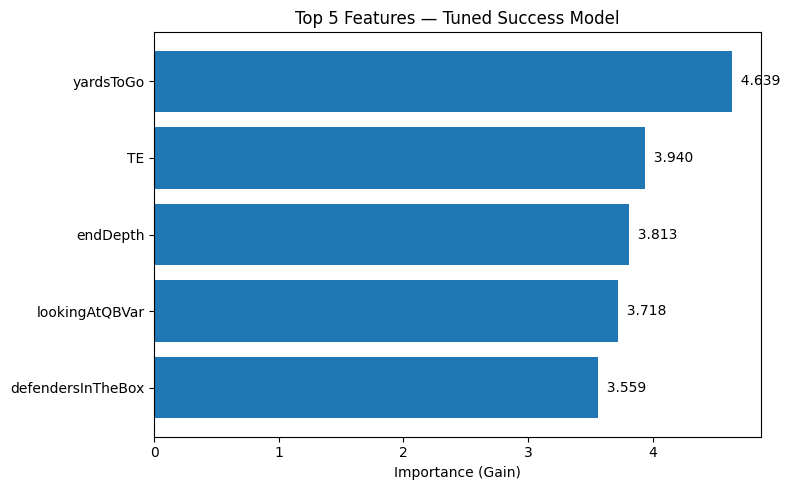

In [36]:
# Ensure your DMatrix kept real column names when training:
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
# dtest  = xgb.DMatrix(X_test,  label=y_test,  feature_names=X_test.columns)
# ...then train xgb_tune as you did.

import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab importances with real names
imp = xgb_tune.get_score(importance_type="gain")  # or "weight", "cover"
imp_df = pd.DataFrame(list(imp.items()), columns=["feature", "importance"])

# Safety: if empty (rare), bail early
if imp_df.empty:
    print("No feature importances found. Check that feature_names were set on DMatrix.")
else:
    # 2) Top 5
    top5 = imp_df.sort_values("importance", ascending=False).head(5)

    # 3) Pretty horizontal bar chart (matplotlib only)
    plt.figure(figsize=(8, 5))
    y = top5["feature"][::-1]        # reverse for top at top
    x = top5["importance"][::-1]
    plt.barh(y, x)
    plt.xlabel("Importance (Gain)")
    plt.title("Top 5 Features — Tuned Success Model")
    # Add value labels
    for i, v in enumerate(x):
        plt.text(v, i, f"  {v:.3f}", va="center")
    plt.tight_layout()
    plt.show()


In [29]:
pred_test_prob = xgb_tune.predict(dtest)
pred_test = (pred_test_prob > 0.5).astype(int)

print("\n=== Tuned XGBoost: Test Metrics ===")
print("LogLoss:", log_loss(y_test, pred_test_prob))
print("Accuracy:", accuracy_score(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=4))


=== Tuned XGBoost: Test Metrics ===
LogLoss: 0.6549897592822183
Accuracy: 0.618018018018018
[[253  57]
 [155  90]]
              precision    recall  f1-score   support

           0     0.6201    0.8161    0.7047       310
           1     0.6122    0.3673    0.4592       245

    accuracy                         0.6180       555
   macro avg     0.6162    0.5917    0.5820       555
weighted avg     0.6166    0.6180    0.5963       555



In [48]:
import seaborn as sns

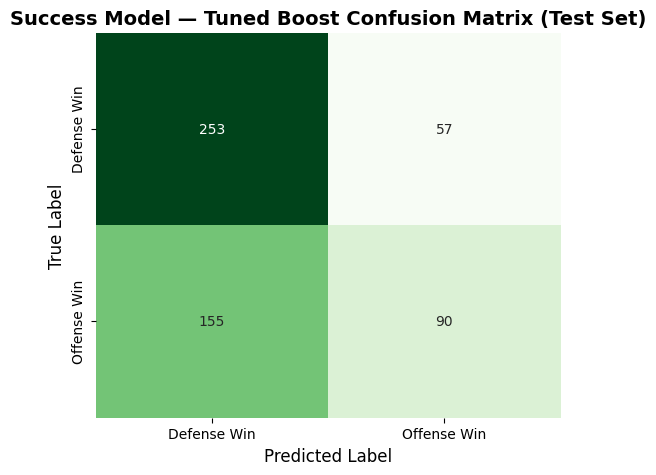

In [49]:
y_pred_prob_succ = xgb_tune.predict(dtest)
y_pred_succ = (y_pred_prob_succ > 0.5).astype(int)

# Confusion matrix
cm_succ = confusion_matrix(y_test, y_pred_succ)

# Labels: 0 = Defense win, 1 = Offense win
labels = ["Defense Win", "Offense Win"]

# Pretty green heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_succ, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels, cbar=False)

plt.title("Success Model — Tuned Boost Confusion Matrix (Test Set)", fontsize=14, weight="bold")
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

In [28]:
full_coverage_data = (
    coverage_preds
    .loc[coverage_preds["pred_man"] > threshold]
    .copy()
)

In [30]:
len(full_coverage_data) # we are predicting on all man to man plays not the other ones

14217

In [31]:
full_keep_cols = [c for c in base_feature_block if c in full_coverage_data.columns]
X_full_raw = full_coverage_data[full_keep_cols].copy()

In [33]:
X_full_raw.head()
X_full_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14217 entries, 15 to 45323
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nFrames              14217 non-null  int64  
 1   WRToCBRatio          14217 non-null  float64
 2   quarter              14217 non-null  int64  
 3   down                 14217 non-null  int64  
 4   yardsToGo            14217 non-null  int64  
 5   yardline_100         14217 non-null  int64  
 6   offenseFormation     14217 non-null  object 
 7   defendersInTheBox    14217 non-null  float64
 8   numberOfPassRushers  14217 non-null  float64
 9   poss_score_diff      14217 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 1.2+ MB


In [34]:
X_full_raw["offenseFormation"] = le.transform(
    X_full_raw["offenseFormation"].astype(str)
)

In [35]:
dfull = xgb.DMatrix(X_full_raw.values)

In [36]:
pred_full_prob = xgb_tune.predict(dfull)

In [37]:
len(pred_full_prob) 

14217

# I have all the probs I need

In [38]:
final_matchup_data = (
    coverage_preds
    .loc[coverage_preds["pred_man"] > threshold]
    .copy()
)

In [39]:
final_matchup_data.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,heightOff,pred_man,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff
15,2018090600,521,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,74,0.927545,1,1,10,90,SINGLEBACK,8.0,3.0,0.0
16,2018090600,545,1,2552689,Ronald Darby,PHI,CB,2495454,Julio Jones,ATL,...,74,0.833723,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
17,2018090600,545,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,74,0.673507,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
18,2018090600,545,1,2557958,Sidney Jones,PHI,CB,2533040,Mohamed Sanu,ATL,...,74,0.965428,1,2,7,93,SINGLEBACK,7.0,4.0,0.0
31,2018090600,992,1,2539334,Desmond Trufant,ATL,CB,2507763,Mike Wallace,PHI,...,74,0.529701,2,1,10,40,SINGLEBACK,7.0,4.0,-3.0


In [40]:

final_matchup_data["pred_offenseWin"] = pred_full_prob

In [41]:
final_matchup_data.head()

,gameId,playId,week,nflIdDef,defPlayerName,defenseTeam,defPos,nflIdOff,offPlayerName,possessionTeam,...,pred_man,quarter,down,yardsToGo,yardline_100,offenseFormation,defendersInTheBox,numberOfPassRushers,poss_score_diff,pred_offenseWin
15,2018090600,521,1,2555383,Jalen Mills,PHI,CB,2495454,Julio Jones,ATL,...,0.927545,1,1,10,90,SINGLEBACK,8.0,3.0,0.0,0.590382
16,2018090600,545,1,2552689,Ronald Darby,PHI,CB,2495454,Julio Jones,ATL,...,0.833723,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.516829
17,2018090600,545,1,2555383,Jalen Mills,PHI,CB,2560854,Calvin Ridley,ATL,...,0.673507,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.516829
18,2018090600,545,1,2557958,Sidney Jones,PHI,CB,2533040,Mohamed Sanu,ATL,...,0.965428,1,2,7,93,SINGLEBACK,7.0,4.0,0.0,0.516829
31,2018090600,992,1,2539334,Desmond Trufant,ATL,CB,2507763,Mike Wallace,PHI,...,0.529701,2,1,10,40,SINGLEBACK,7.0,4.0,-3.0,0.462599


In [42]:
len(final_matchup_data)

14217

In [43]:
final_matchup_data.to_csv("final_matchup_data_v2.csv", index=False)
print("\nSaved final_matchup_data.csv")



Saved final_matchup_data.csv
